<a href="https://colab.research.google.com/github/syusuke9999/Sequence-to-Sequence-/blob/main/%E3%82%A2%E3%83%86%E3%83%B3%E3%82%B7%E3%83%A7%E3%83%B3%E3%82%92%E7%94%A8%E3%81%84%E3%81%9F%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E6%A9%9F%E6%A2%B0%E7%BF%BB%E8%A8%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# アテンションを用いたニューラル機械翻訳

Note: これらのドキュメントは私たちTensorFlowコミュニティが翻訳したものです。コミュニティによる 翻訳は**ベストエフォート**であるため、この翻訳が正確であることや[英語の公式ドキュメント](https://www.tensorflow.org/?hl=en)の 最新の状態を反映したものであることを保証することはできません。 この翻訳の品質を向上させるためのご意見をお持ちの方は、GitHubリポジトリ[tensorflow/docs](https://github.com/tensorflow/docs)にプルリクエストをお送りください。 コミュニティによる翻訳やレビューに参加していただける方は、 [docs-ja@tensorflow.org メーリングリスト](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ja)にご連絡ください。

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [38]:
import io
import os
import pickle
import re
import sys
import time
import unicodedata
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import font_manager
import numpy as np
import numpy as numpy
import tensorflow as tf
from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
!apt-get -y install fonts-ipafont-gothic
!apt autoremove
plt.rcParams["font.family"]='IPAGothic'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


このノートブックでは、英語から日本語への翻訳を行う Sequence to Sequence (seq2seq) モデルを訓練します。このチュートリアルは、 Sequence to Sequence モデルの知識があることを前提にした上級編のサンプルです。

このノートブックのモデルを訓練すると、_"are you still at home?"_  のような英語の文を入力して、和訳：  _"まだ家にいるの？"_  を得ることができます。

この翻訳品質はおもちゃとしてはそれなりのものですが、生成されたアテンションの図表の方が面白いかもしれません。これは、翻訳時にモデルが入力文のどの部分に注目しているかを表しています。

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: このサンプルは P100 GPU 1基で実行した場合に約 10 分かかります。

In [65]:
!rm -r /root/.cache/matplotlib/

rm: cannot remove '/root/.cache/matplotlib/': No such file or directory


In [41]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr  4 08:03:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    35W / 250W |   8751MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [42]:
# 形態素分析ライブラリーMeCab と 辞書(mecab-ipadic-NEologd)のインストール 
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab
!git clone --depth=1 -b v0.0.7 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n
!echo `mecab-config --dicdir`"/mecab-ipadic-neologd"
!pip install mecab-python3
!sudo apt autoremove
# シンボリックリンクによるエラー回避
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

Reading package lists...
Building dependency tree...
Reading state information...
libmecab-dev is already the newest version (0.996-5).
mecab is already the newest version (0.996-5).
mecab-ipadic-utf8 is already the newest version (2.7.0-20070801+main-1).
python-mecab is already the newest version (0.99.6-2).
curl is already the newest version (7.58.0-2ubuntu3.16).
file is already the newest version (1:5.32-2ubuntu0.4).
git is already the newest version (1:2.17.1-1ubuntu0.9).
sudo is already the newest version (1.8.21p2-3ubuntu1.4).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
fatal: destination path 'mecab-ipadic-neologd' already exists and is not an empty directory.
[install-mecab-ipadic-NEologd] : Start..
[install-mecab-ipadic-NEologd] : Check the existance of libraries
[install-mecab-ipadic-NEologd] :     find => ok
[install-mecab-ipadic-NEologd] :     sort => ok
[install-mecab-ipadic-NEologd] :     head => ok
[install-mecab-ipadic-NEologd] :     cut => ok
[insta

In [66]:
# シンボリックリンクによるエラー回避
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

ln: failed to create symbolic link '/usr/local/etc/mecabrc': File exists


In [43]:
import MeCab
tokenizer = MeCab.Tagger('/usr/local/etc/mecabrc')

In [44]:
def is_japanese(string):
    for ch in string:
        name = unicodedata.name(ch) 
        if "CJK UNIFIED" in name \
        or "HIRAGANA" in name \
        or "KATAKANA" in name:
            return True
    return False
# ユニコードファイルを ascii に変換
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFKC', s)
        if unicodedata.category(c) != 'Mn')
def preprocess_sentence(w):
    w = unicode_to_ascii(w)
    if is_japanese(w) is True:
        w = re.sub(r"(\d{1,3})(,)(\d{3})", r'\1\3', w)
        w = re.sub(r"([？。！、])", r" \1 ", w)
        # Mecabを使用して、wとして渡されたテキストを形態素解析して分かち書きしたものを返す。
        mecab = MeCab.Tagger ("-Owakati")
        w = mecab.parse (w)
    w = w.lower()
    w = re.sub(r"(\d{1,3})(,)(\d{3})", r'\1\3', w)
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = w.lower()
    ''.join(w).splitlines()
    # 文の開始と終了のトークンを付加
    # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
    w = w.rstrip().strip()
    w.replace('\r','')
    w = '<start> ' + w + ' <end>'
    return w

In [45]:
en_sentence = "It's all you can drink for 2 hours for 2,500 yen."
jp_sentence = "2時間2,500円で飲み放題。"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(jp_sentence))

<start> it's all you can drink for 2 hours for 2500 yen . <end>
<start> 2 時間 2500 円 で 飲み 放題 。 <end>


In [46]:
# 1. アクセント記号を除去
# 2. 文をクリーニング
# 3. [ENGLISH, JAPANESE] の形で単語のペアを返す
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pare = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    return zip(*word_pare)

In [10]:
# ファイルパスの指定
path_to_file = tf.keras.utils.get_file('/content/drive/MyDrive/eng_jpn/eng_jpn.txt', origin='https://storage.googleapis.com/eng_jpn_corpus/eng_jpn.txt')

In [47]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [48]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

In [12]:
en, jp = create_dataset(path_to_file, 500)
# チェックポイントのパスを設定
checkpoint_path = '/content/drive/MyDrive/Checkpoints/'
print(en[-1])
print(jp[-1])

NameError: ignored

In [49]:
def load_dataset(path, num_examples=None):
    # クリーニングされた入力と出力のペアを生成
    inp_lang, targ_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### 実験を速くするためデータセットのサイズを制限（オプション）

100,000 を超える文のデータセットを使って訓練するには長い時間がかかります。訓練を速くするため、データセットのサイズを 30,000 に制限することができます（もちろん、データが少なければ翻訳の品質は低下します）。

## データセットのダウンロードと準備

ここでは、http://www.manythings.org/anki/ で提供されている言語データセットを使用します。このデータセットには、次のような書式の言語翻訳ペアが含まれています。




### May I borrow this book?	この本を借りてもいいですか？



さまざまな言語が用意されていますが、ここでは英語－日本語のデータセットを使用します。利便性を考えてこのデータセットは Google Cloud 上に用意してありますが、ご自分でダウンロードすることも可能です。データセットをダウンロードしたあと、データを準備するために下記のようないくつかの手順を実行します。

1. それぞれの文ごとに、*開始* と *終了* のトークンを付加する
2. 特殊文字を除去して文をきれいにする
3. 単語インデックスと逆単語インデックス（単語 → id と id → 単語のマッピングを行うディクショナリ）を作成する
4. 最大長にあわせて各文をパディングする

In [15]:
# このサイズのデータセットで実験
checkpoint_path = '/content/drive/MyDrive/Checkpoints/'

input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file)

In [50]:
checkpoint_path = '/content/drive/MyDrive/Checkpoints/'

In [51]:
# loading
input_tensor_train = numpy.load(checkpoint_path + 'Tokenizer/input_tensor_train.npy')
input_tensor_val = numpy.load(checkpoint_path + 'Tokenizer/input_tensor_val.npy')
target_tensor_train = numpy.load(checkpoint_path + 'Tokenizer/target_tensor_train.npy')
target_tensor_val= numpy.load(checkpoint_path + 'Tokenizer/target_tensor_val.npy')
input_tensor = numpy.load(checkpoint_path + 'Tokenizer/input_tensor.npy')
target_tensor = numpy.load(checkpoint_path + 'Tokenizer/target_tensor.npy')

In [52]:
with open(checkpoint_path + 'Tokenizer/inp_lang.pickle', 'rb') as handle:
    inp_lang = pickle.load(handle)
with open(checkpoint_path + 'Tokenizer/targ_lang.pickle', 'rb') as handle:
    targ_lang = pickle.load(handle)
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

**再実行の際はここから**

In [49]:
# 80-20で分割を行い、訓練用と検証用のデータセットを作成
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, shuffle=True, test_size=0.2)
# 長さを表示
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))
# saving
numpy.save(checkpoint_path + 'Tokenizer/input_tensor_train.npy',input_tensor_train)
numpy.save(checkpoint_path + 'Tokenizer/input_tensor_val.npy',input_tensor_val)
numpy.save(checkpoint_path + 'Tokenizer/target_tensor_train.npy',target_tensor_train)
numpy.save(checkpoint_path + 'Tokenizer/target_tensor_val.npy',target_tensor_val)
numpy.save(checkpoint_path + 'Tokenizer/input_tensor.npy',input_tensor)
numpy.save(checkpoint_path + 'Tokenizer/target_tensor.npy',target_tensor)

53548 53548 13387 13387


In [53]:
# ターゲットテンソルの最大長を計算
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)
# 長さを表示
print(max_length_targ, max_length_inp)
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))
print ("入力言語;単語マッピングへのインデックス")
convert(inp_lang, input_tensor_train[121])
print ()
print ("対象言語;単語マッピングへのインデックス")
convert(targ_lang, target_tensor_train[121])

60 50
入力言語;単語マッピングへのインデックス
1 ----> <start>
137 ----> does
326 ----> anyone
21 ----> have
70 ----> an
3837 ----> iphone
3372 ----> charger
8 ----> ?
2 ----> <end>

対象言語;単語マッピングへのインデックス
1 ----> <start>
60 ----> 誰
18 ----> か
4997 ----> iphone
6 ----> の
2937 ----> 充電
2661 ----> 器
116 ----> 持っ
9 ----> て
42 ----> ませ
23 ----> ん
18 ----> か
16 ----> ?
2 ----> <end>


### tf.data データセットの作成

In [54]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 2
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

## エンコーダー・デコーダーモデルの記述

TensorFlow の [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt) に記載されているアテンション付きのエンコーダー・デコーダーモデルを実装します。この例では、最新の API セットを使用します。このノートブックは、上記の seq2seq チュートリアルにある [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) を実装します。下図は、入力の単語ひとつひとつにアテンション機構によって重みが割り当てられ、それを使ってデコーダーが文中の次の単語を予測することを示しています。下記の図と式は [Luong の論文](https://arxiv.org/abs/1508.04025v5) にあるアテンション機構の例です。

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

入力がエンコーダーを通過すると、shape が *(batch_size, max_length, hidden_size)* のエンコーダー出力と、shape が *(batch_size, hidden_size)* のエンコーダーの隠れ状態が得られます。

下記に実装されている式を示します。

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

このチュートリアルでは、エンコーダーでは [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) を使用します。簡略化した式を書く前に、表記方法を定めましょう。

* FC = 全結合 (Dense) レイヤー
* EO = エンコーダーの出力
* H = 隠れ状態
* X = デコーダーへの入力


擬似コードは下記のとおりです。

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`　softmax は既定では最後の軸に対して実行されますが、スコアの shape が *(batch_size, max_length, hidden_size)*　であるため、*最初の軸* に適用します。`max_length` は入力の長さです。入力それぞれに重みを割り当てようとしているので、softmax はその軸に適用されなければなりません。
* `context vector = sum(attention weights * EO, axis = 1)`. 上記と同様の理由で axis = 1 に設定しています。
* `embedding output` = デコーダーへの入力 X は Embedding レイヤーを通して渡されます。
* `merged vector = concat(embedding output, context vector)`
* この結合されたベクトルがつぎに GRU に渡されます。

それぞれのステップでのベクトルの shape は、コードのコメントに指定されています。

In [55]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))
    def restore_from_checkpoint(self):
        return tf.train.Checkpoint(tf.train.latest_checkpoint(checkpoint_path))
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [56]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # スコアを計算するためにこのように加算を実行する
    hidden_with_time_axis = tf.expand_dims(query, 1)
    # score shape == (batch_size, max_length, 1)
    # スコアを self.V に適用するために最後の軸は 1 となる
    # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))
    # attention_weights の shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    # context_vector の合計後の shape == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights
attention_layer = BahdanauAttention(10)
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    # アテンションのため
    self.attention = BahdanauAttention(self.dec_units)
  def call(self, x, hidden, enc_output):
    # enc_output の shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)
    # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # 結合したベクトルを GRU 層に渡す
    output, state = self.gru(x)
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    # output shape == (batch_size, vocab)
    x = self.fc(output)
    return x, state, attention_weights
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

## オプティマイザと損失関数の定義

## チェックポイント（オブジェクトベースの保存）

In [57]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [58]:
# オプティマイザと損失関数、チェックポイントの定義
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=decoder)
manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_path, max_to_keep=5)

## 訓練

1. *入力* を *エンコーダー* に通すと、*エンコーダー出力* と *エンコーダーの隠れ状態* が返される
2. エンコーダーの出力とエンコーダーの隠れ状態、そしてデコーダーの入力（これが *開始トークン*）がデコーダーに渡される
3. デコーダーは *予測値* と *デコーダーの隠れ状態* を返す
4. つぎにデコーダーの隠れ状態がモデルに戻され、予測値が損失関数の計算に使用される
5. デコーダーへの次の入力を決定するために *Teacher Forcing* が使用される
6. *Teacher Forcing* は、*正解単語* をデコーダーの *次の入力* として使用するテクニックである
7. 最後に勾配を計算し、それをオプティマイザに与えて誤差逆伝播を行う

In [59]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        # Teacher Forcing - 正解値を次の入力として供給
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            # Teacher Forcing を使用
            dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [60]:
def Train_Translation(EPOCHS,continue_training=False):
    Restored = False
    if continue_training is True and Restored is False:
        checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
    for epoch in range(EPOCHS):
        start = time.time()
        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0
        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step(inp, targ, enc_hidden)
            total_loss += batch_loss
            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
        #１エポックごとにモデル（のチェックポイント）を保存
        checkpoint.save(checkpoint_path + 'training_checkpoints')
        print('\rEpoch {} Loss {:.4f}'.format(epoch + 1,(total_loss / steps_per_epoch), end=''))
        print('\n' + '1エポックにかかった時間 {} 秒\n'.format(time.time() - start))
        print("終了までの予想時間：{} 分\n".format(((time.time() - start)*(EPOCHS - (epoch + 1)))/60))

In [61]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [27]:
Train_Translation(1,True)

Epoch 1 Batch 0 Loss 0.9094
Epoch 1 Batch 100 Loss 0.5026
Epoch 1 Batch 200 Loss 0.1511
Epoch 1 Batch 300 Loss 0.2548
Epoch 1 Batch 400 Loss 0.3809
Epoch 1 Batch 500 Loss 0.1871
Epoch 1 Batch 600 Loss 0.2368
Epoch 1 Batch 700 Loss 0.1538
Epoch 1 Batch 800 Loss 0.2393
Epoch 1 Batch 900 Loss 0.2039
Epoch 1 Batch 1000 Loss 0.4880
Epoch 1 Batch 1100 Loss 0.3124
Epoch 1 Batch 1200 Loss 0.3868
Epoch 1 Batch 1300 Loss 0.4098
Epoch 1 Batch 1400 Loss 0.7695
Epoch 1 Batch 1500 Loss 0.2476
Epoch 1 Batch 1600 Loss 0.0547
Epoch 1 Batch 1700 Loss 0.2967
Epoch 1 Batch 1800 Loss 0.4171
Epoch 1 Batch 1900 Loss 0.2766
Epoch 1 Batch 2000 Loss 0.4663
Epoch 1 Batch 2100 Loss 0.2713
Epoch 1 Batch 2200 Loss 0.3743
Epoch 1 Batch 2300 Loss 0.1153
Epoch 1 Batch 2400 Loss 0.6012
Epoch 1 Batch 2500 Loss 0.4174
Epoch 1 Batch 2600 Loss 0.1749
Epoch 1 Batch 2700 Loss 0.3103
Epoch 1 Batch 2800 Loss 0.0795
Epoch 1 Batch 2900 Loss 0.1660
Epoch 1 Batch 3000 Loss 0.4349
Epoch 1 Batch 3100 Loss 0.2022
Epoch 1 Batch 3200 L

In [67]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot
# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
    #matplotlib.rcParams['font.family'] = "IPAGothic"
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    jp_font = {'fontname':'IPAGothic'}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90, **jp_font)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, **jp_font)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('入力文: %s' % (sentence))
    translated = result.replace(' ','')
    translated = translated.replace('<end>','')
    translated = translated.replace('<start>','')
    print('予測される翻訳: {}'.format(translated))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))


## 翻訳

* 評価関数は、*Teacher Forcing* を使わないことを除いては、訓練ループと同様である。
*タイムステップごとのデコーダーへの入力は、過去の予測値に加えて、隠れ状態とエンコーダーのアウトプットである。
* モデルが終了トークンを予測したら、予測を停止する。
* また、タイムステップごとのアテンションの重みを保存する。

Note: エンコーダーの出力は 1 つの入力に対して 1 回だけ計算されます。

## 最後のチェックポイントを復元しテストする

入力文: <start> it is very cold here . <end>
予測される翻訳: ここは寒い。


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12371 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12399 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23506 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12290 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12371 missing from current font.
  font.set_

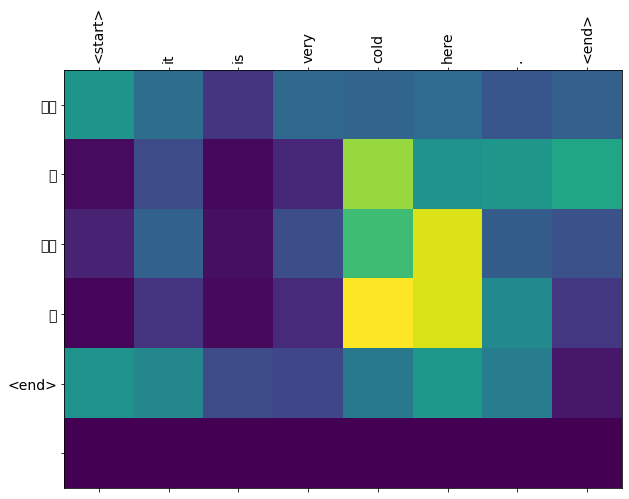

入力文: <start> this is my life . <end>
予測される翻訳: これは私の人生なんだ。


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12394 missing from current font.
  font.set_

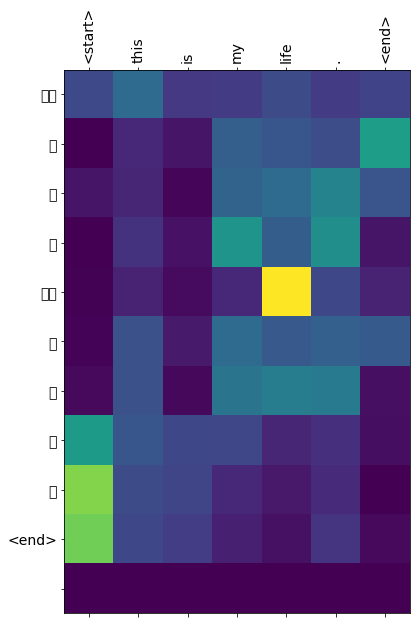

入力文: <start> are you still at home ? <end>
予測される翻訳: まだ家にいるの?


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12414 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23478 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12395 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12427 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12414 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 23478 missing from current font.
  font.set_te

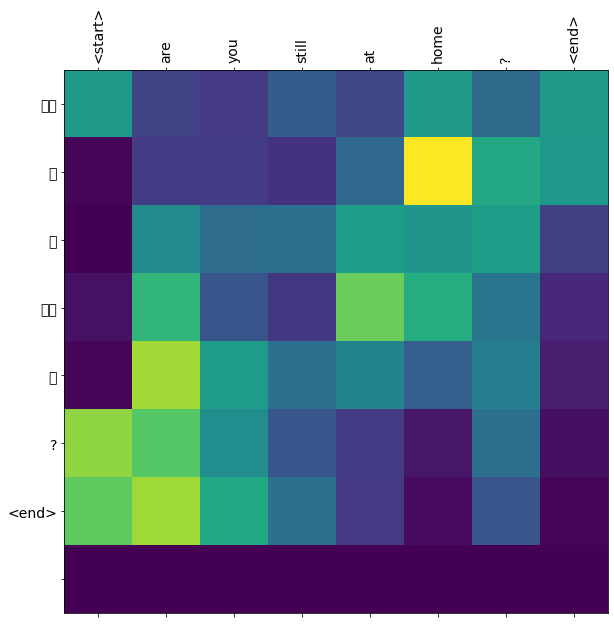

入力文: <start> my work time for the last three months . <end>
予測される翻訳: うちの前に行く途中でパートしている。


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12385 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 34892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12367 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36884 missing from current font.
  font.set_

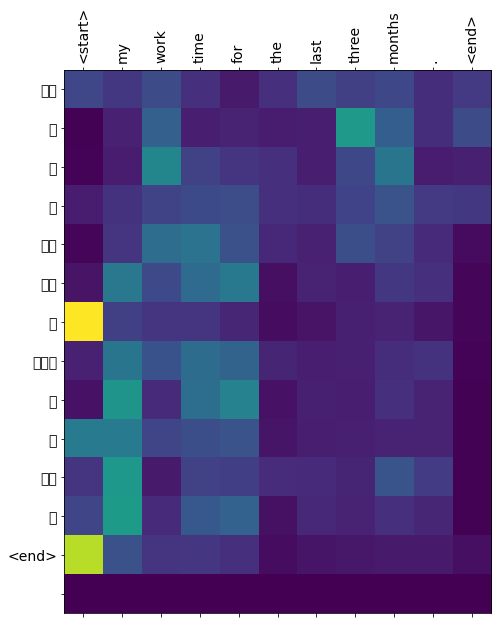

入力文: <start> i made an appointment to see the doctor at four o'clock . <end>
予測される翻訳: 6時までに診ているように診ているように診ているように診ているように診ているように診ているように診ているように診ているように診ているように診ているように診ているように診


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35386 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 35386 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12424 missing from current font.
  font.set_text

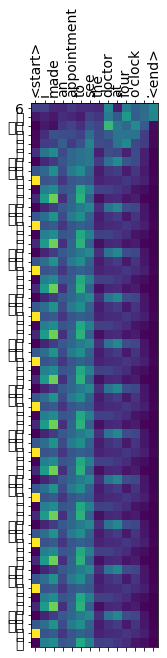

入力文: <start> can you imagine what the 21st century will be like ? <end>
予測される翻訳: 6月1世紀が好き?


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19990 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22909 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12365 missing from current font.
  font.set_

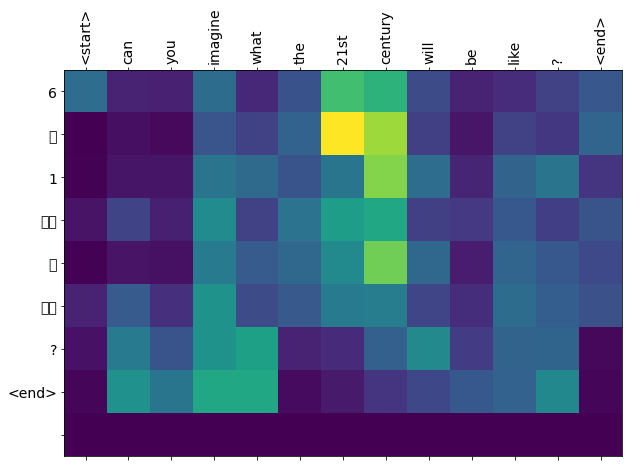

In [68]:
translate('It is very cold here.')
translate('This is my life.')
translate('Are you still at home?')
translate('My work time for the last three months.')
translate(u'I made an appointment to see the doctor at four o\'clock.')
translate('Can you imagine what the 21st century will be like?')

入力文: <start> this is my life . <end>
予測される翻訳: これは私の人生なんだ。


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12371 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12428 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12399 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_

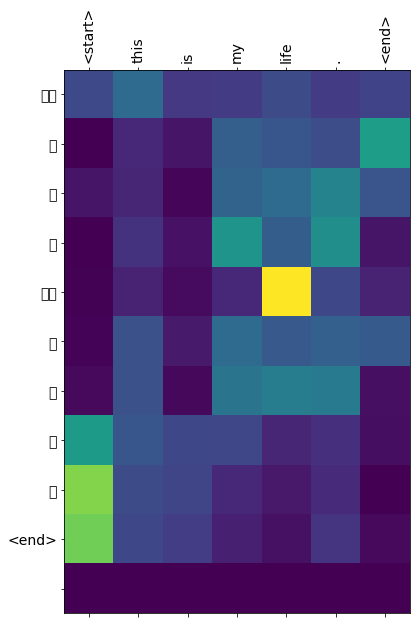

In [30]:
translate('This is my life.')

入力文: <start> are you still at home ? <end>
予測される翻訳: まだ家にいるの?


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12414 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12384 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23478 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12395 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12427 missing from current font.
  font.set_

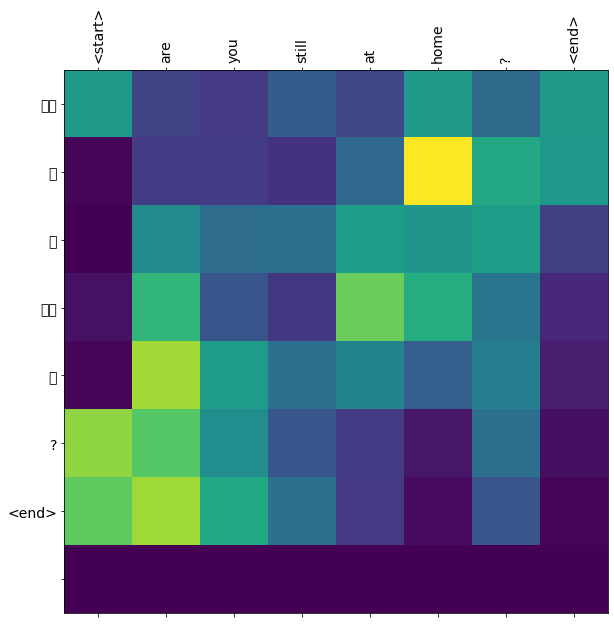

In [31]:
translate('Are you still at home?')

入力文: <start> the journey of life will continue . <end>
予測される翻訳: 旅行は決して大人として働き続けている。


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 34892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12399 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27770 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12390 missing from current font.
  font.set_

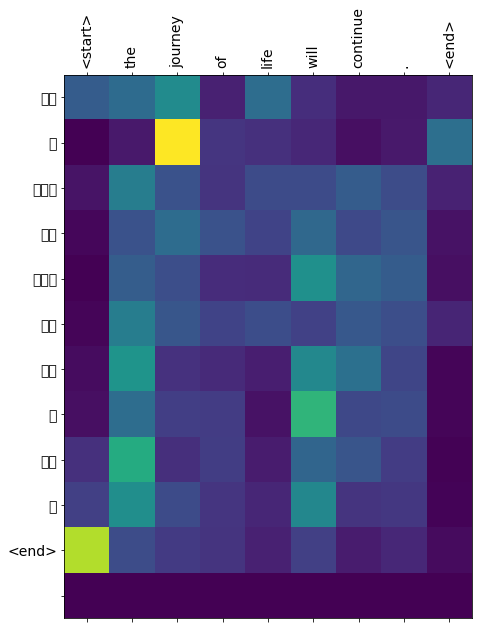

In [32]:
translate('The journey of life will continue.')

入力文: <start> i made an appointment to see the doctor at four o'clock . <end>
予測される翻訳: 6時までに診ているように診ているように診ているように診ているように診ているように診ているように診ているように診ているように診ているように診ているように診ているように診


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26178 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12414 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12391 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12395 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35386 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12390 missing from current font.
  font.set_

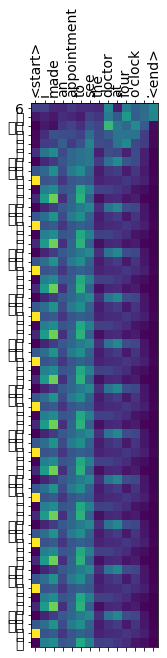

In [33]:
translate('I made an appointment to see the doctor at four o\'clock.')

入力文: <start> can you imagine ? <end>
予測される翻訳: 想像していただけますか?


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24819 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20687 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12390 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12383 missing from current font.
  font.set_

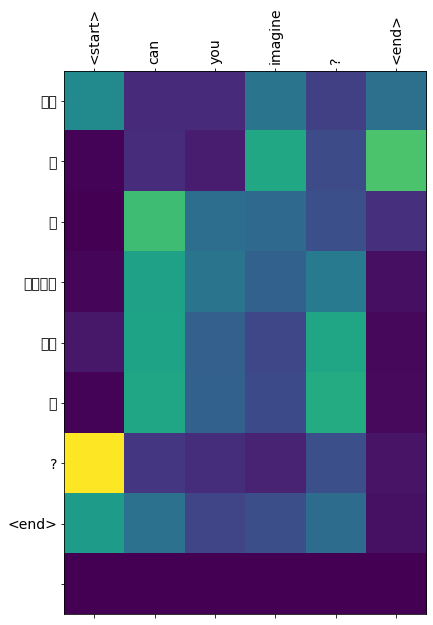

In [34]:
translate('Can you imagine?')

## 次のステップ

* [異なるデータセットをダウンロード](http://www.manythings.org/anki/)して翻訳の実験を行ってみよう。たとえば英語からドイツ語や、英語からフランス語。
* もっと大きなデータセットで訓練を行ったり、もっと多くのエポックで訓練を行ったりしてみよう。